## Classification I

The learning objectives for this Lab are to:
- Get started with MLJ;
- Experiment with kNearestNeighbour classifiers. 

### Get started with MLJ

From here we start to use MLJ, which is a Machine Learning package written completely in Julia, featuring an easy-to-use data access interface, efficient implementation of more than 160 algorithms, and flexible pipeline designs. One advantage of MLJ, compared with some major competitors, is its ability to handle categorical data directly. 

Let's add the MLJ package (if you haven't done so) and get started: 

In [1]:
#import Pkg; Pkg.add("MLJ")

In [2]:
using MLJ

MLJ uses a data table structure that's contains attribute names (think about something between a heavy DataFrame and a bare data matrix). For example, we can create a data table as follows - note that it can contain different data types for different attributes, allow missing values, and has attributes organized as vectors (in the same old Julia style;0): 

In [3]:
X = (height   = [185, 163, 114, 180],
     weight     = [72.3, 84.2, 31.8, 97.1],
     admitted = ["yes", "no", missing, "yes"]);

We can check out the attribute (column) vectors using an attribute name, or an index:

In [4]:
X[:height]   # the same as X[1]

4-element Vector{Int64}:
 185
 163
 114
 180

In [5]:
X[3]

4-element Vector{Union{Missing, String}}:
 "yes"
 "no"
 missing
 "yes"

To select multiple attributes (i.e. "columns" in a spreadsheet), we can use:

In [6]:
selectcols(X,[1,3])  # this is about selecting attributes, i.e. "columns" in a spreadsheet

(height = [185, 163, 114, 180],
 admitted = Union{Missing, String}["yes", "no", missing, "yes"],)

And "selectrows" is about selecting instances, i.e., "rows" in a spreadsheet: 

In [7]:
selectrows(X, 1:2)      # select rows 1 & 2

(height = [185, 163],
 weight = [72.3, 84.2],
 admitted = Union{Missing, String}["yes", "no"],)

We can check out the schema of the data table, revealing each attribute's name, data type, as well as a scientific type: 

In [8]:
schema(X)

┌──────────┬─────────────────────────┬────────────────────────┐
│ names    │ scitypes                │ types                  │
├──────────┼─────────────────────────┼────────────────────────┤
│ height   │ Count                   │ Int64                  │
│ weight   │ Continuous              │ Float64                │
│ admitted │ Union{Missing, Textual} │ Union{Missing, String} │
└──────────┴─────────────────────────┴────────────────────────┘


In [9]:
schema(X).names   # get the attribute names

(:height, :weight, :admitted)

If we want to use DataFrames utilities, we can easily transform our data into a DataFrame:

In [10]:
using DataFrames
df = DataFrame(X)

Row,height,weight,admitted
,Int64,Float64,String?
1,185,72.3,yes
2,163,84.2,no
3,114,31.8,missing
4,180,97.1,yes


### kNN Classification

#### Data preparation
For further experiments, we load in the Iris dataset:

In [11]:
X, y = @load_iris; # loads the iris dataset from MLJBase

We can check out the attribute names:

In [12]:
schema(X).names

(:sepal_length, :sepal_width, :petal_length, :petal_width)

In [13]:
X

(sepal_length = [5.1, 4.9, 4.7, 4.6, 5.0, 5.4, 4.6, 5.0, 4.4, 4.9  …  6.7, 6.9, 5.8, 6.8, 6.7, 6.7, 6.3, 6.5, 6.2, 5.9],
 sepal_width = [3.5, 3.0, 3.2, 3.1, 3.6, 3.9, 3.4, 3.4, 2.9, 3.1  …  3.1, 3.1, 2.7, 3.2, 3.3, 3.0, 2.5, 3.0, 3.4, 3.0],
 petal_length = [1.4, 1.4, 1.3, 1.5, 1.4, 1.7, 1.4, 1.5, 1.4, 1.5  …  5.6, 5.1, 5.1, 5.9, 5.7, 5.2, 5.0, 5.2, 5.4, 5.1],
 petal_width = [0.2, 0.2, 0.2, 0.2, 0.2, 0.4, 0.3, 0.2, 0.2, 0.1  …  2.4, 2.3, 1.9, 2.3, 2.5, 2.3, 1.9, 2.0, 2.3, 1.8],)

Let's take a look of the y vector:

In [14]:
y

150-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 "setosa"
 ⋮
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"
 "virginica"

This reveals something (potentially) problematic: the data instances are ordered, first 1/3 being of the "setosa" class, 2nd for "versicolor", and 3rd for "virginica". We'd need to shuffle the data when extracting training and testing samples - they should cover all three classes.  

**Task 1**: Extract only two attributes "sepal_length" and "sepal_width" and form a data table X1. Generate a scatter plot of X1 using the two attributes, with data points of different classes marked by different colours.   

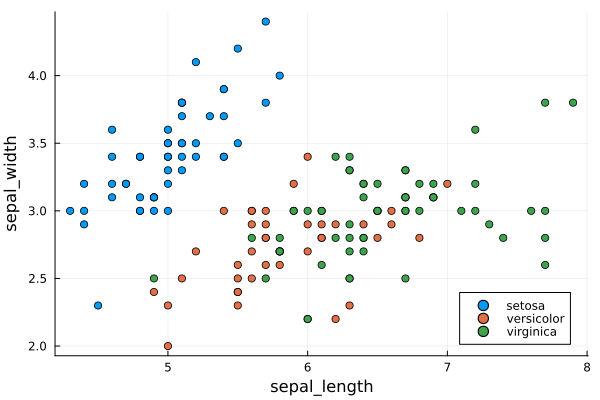

In [15]:
using Plots

X1 = selectcols(X, [1,2]) 
scatter(X1[1], X1[2], xlabel=schema(X).names[1], ylabel=schema(X).names[2], group=y, legend=:bottomright)

#### Building our first classifier machine

A typical *workflow* for using MLJ is as follows. After getting the data ready, we can choose an algorithm for creating a *model*, but this model is only a container that holds relevant hyperparameters. To flesh out the model, we need to create a *machine* to wrap in the model and the dataset to be used. 

Up till now, nothing really happens yet. We now need to train the machine, by calling a fit!() method. This results in adapting the model parameters or weights, i.e., training it. 

To test the trained machine on our data, we call predict() or predict_mode(), the former reporting probabilistic prediction, the latter reporting just the final decision. For example, testing a case "x" with predict(x) we may get 0.90 probability for Class 1, 0.10 probability for Class 2; while with predict_mode(x) we will simply get the assigned class label of "1". 

Let us try it out with a nearest neighbour classifier (k=3). Note we randomly split the dataset into a training set and a testing set, with "shuffle=true". It is not necessary to create new arrays for these (sub)sets, so in fact only index arrays ("tr_inds" and "te_inds") are generated and used for extracting training and testing samples. 

In [16]:
using Random
Random.seed!(0)
tr_inds, te_inds = partition(1:nrows(X1), 0.7, shuffle=true)

([121, 143, 59, 147, 61, 15, 87, 56, 104, 89  …  42, 41, 49, 139, 19, 43, 118, 70, 138, 111], [110, 100, 32, 98, 48, 82, 30, 90, 2, 77  …  6, 140, 79, 25, 20, 1, 145, 54, 83, 65])

Now we experiment with our first classifier, in four steps: 
1. Create a model (specifying parameters)
2. Create a machine (using the model and data)
3. fit! (training)
4. predict (testing)

Click and run through the following cells:

In [17]:
#import Pkg; Pkg.add("NearestNeighborModels")
using NearestNeighborModels 

In [18]:
knnc = KNNClassifier(K=3)             # wrap in parameters into a model

KNNClassifier(
  K = 3, 
  algorithm = :kdtree, 
  metric = Euclidean(0.0), 
  leafsize = 10, 
  reorder = true, 
  weights = Uniform())

In [19]:
knnc_mach = machine(knnc, X1, y)      # create a machine using the model and data

untrained Machine; caches model-specific representations of data
  model: KNNClassifier(K = 3, …)
  args: 
    1:	Source @063 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @034 ⏎ AbstractVector{Multiclass{3}}


In [20]:
MLJ.fit!(knnc_mach, rows=tr_inds)

[ Info: Training machine(KNNClassifier(K = 3, …), …).


trained Machine; caches model-specific representations of data
  model: KNNClassifier(K = 3, …)
  args: 
    1:	Source @063 ⏎ Table{AbstractVector{Continuous}}
    2:	Source @034 ⏎ AbstractVector{Multiclass{3}}


Now that the model has been trained, we can generate the predictions on the testing instances. The predict_mode() function gives the label prediction for the testing instances:

In [21]:
ypred = predict_mode(knnc_mach, rows=te_inds)

45-element CategoricalArrays.CategoricalArray{String,1,UInt32}:
 "virginica"
 "versicolor"
 "setosa"
 "virginica"
 "setosa"
 "versicolor"
 "setosa"
 "versicolor"
 "setosa"
 "virginica"
 "setosa"
 "setosa"
 "setosa"
 ⋮
 "versicolor"
 "setosa"
 "setosa"
 "virginica"
 "versicolor"
 "setosa"
 "setosa"
 "setosa"
 "virginica"
 "versicolor"
 "versicolor"
 "versicolor"

We can calculate the prediction accuracy: 

In [22]:
accuracy(ypred, y[te_inds])

0.8444444444444444

The accuracy() function basically does the same job as the following line: 

In [23]:
count(ypred .== y[te_inds])/length(te_inds)

0.8444444444444444

If we are after the classification error, another function is provided:

In [24]:
misclassification_rate(ypred, y[te_inds])

0.15555555555555556

MLJ provides a predict() function to give probabilistic prediction. Here's an example - the kNN model is quite sure about the classification of the test case into "setosa" (with a probability of 1.0): 

In [25]:
predict(knnc_mach, [5.1 0.4])

1-element CategoricalDistributions.UnivariateFiniteVector{Multiclass{3}, String, UInt32, Float64}:
 UnivariateFinite{Multiclass{3}}(setosa=>0.333, versicolor=>0.667, virginica=>0.0)

**Task 2.** Using the same training and testing split, try k values over the range 1:20 and plot out an accuracy run-chart for classifiers using different k's with both the training accarucy (i.e. obtained on the training data) and the testing accuracy (i.e. obtained on the testing data).  

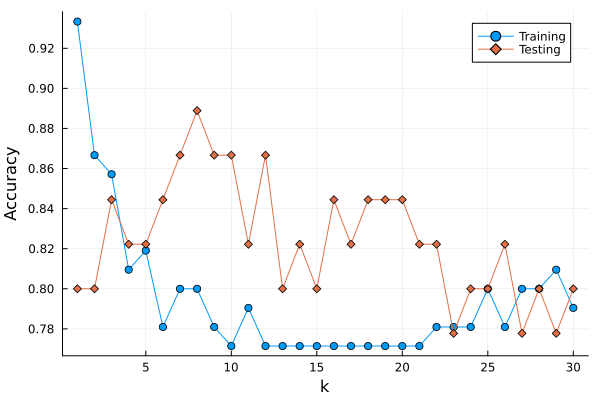

In [26]:
# code for Task 2
accu_tr = []
accu_te = []

ks = 1:30
for k in ks
    knnc = KNNClassifier(K=k) # KNNClassifier instantiation
    knnc_mach = machine(knnc, X1, y) # wrap model and required data in an MLJ machine
    MLJ.fit!(knnc_mach, rows=tr_inds, verbosity=0) # train machine on a subset of the wrapped data `X`
    push!(accu_tr, accuracy(predict_mode(knnc_mach, rows=tr_inds), y[tr_inds]))    
    push!(accu_te, accuracy(predict_mode(knnc_mach, rows=te_inds), y[te_inds]))
end
plot(ks, accu_tr, label="Training", marker=:c, xlabel="k", ylabel="Accuracy")
plot!(ks, accu_te, label="Testing", marker=:d)

**Task 3.** Use the distance-weighted voting scheme for kNN, regenerate the classifiers' accuracy run-chart. (Tip: After the "K=k" option, add "weights = Inverse()" when creating a model). 

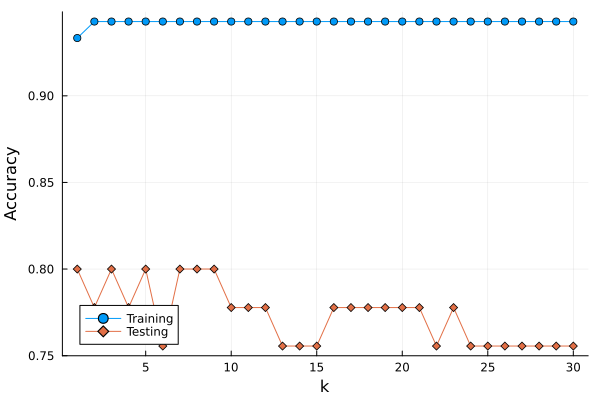

In [27]:
# code for Task 3
accu_tr = []
accu_te = []

ks = 1:30
for k in ks
    knnc = KNNClassifier(K=k, weights = Inverse()) # KNNClassifier instantiation
    knnc_mach = machine(knnc, X1, y) # wrap model and required data in an MLJ machine
    MLJ.fit!(knnc_mach, rows=tr_inds, verbosity=0) # train machine on a subset of the wrapped data `X`
    push!(accu_tr, accuracy(predict_mode(knnc_mach, rows=tr_inds), y[tr_inds]))    
    push!(accu_te, accuracy(predict_mode(knnc_mach, rows=te_inds), y[te_inds]))
end
plot(ks, accu_tr, label="Training", marker=:c, xlabel="k", ylabel="Accuracy")
plot!(ks, accu_te, label="Testing", marker=:d)

## Decision boundary

Let's take a look of the decision boundaries generated by the kNN classifiers. The following code uses Plots' contourf() to plot out the prediction over a mesh grid of the two attributes. 

[ Info: Training machine(KNNClassifier(K = 1, …), …).


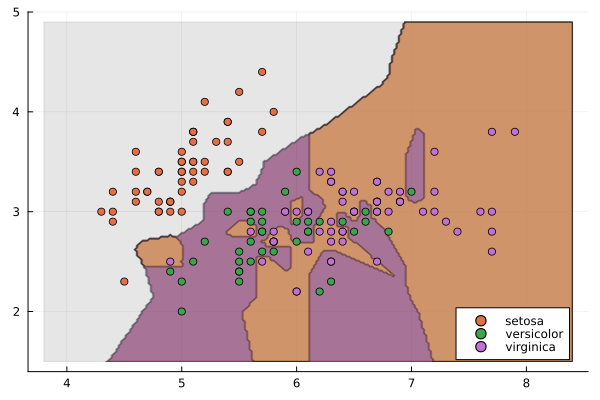

In [28]:
knnc = KNNClassifier(K=1)
knnc_ma = machine(knnc, X1, y)
MLJ.fit!(knnc_ma, rows=tr_inds)

dim1_min = minimum(X1[1])
dim1_max = maximum(X1[1])
xx = dim1_min-0.5:0.02:dim1_max+0.5
dim2_min = minimum(X1[2])
dim2_max = maximum(X1[2])
yy = dim2_min-0.5:0.02:dim2_max+0.5
z = []
for d1 in xx
    for d2 in yy
        push!(z, string(predict_mode(knnc_ma, [d1 d2])))
    end
end
zz = reshape(z, (length(yy), length(xx)))
        
zz = coerce(zz, OrderedFactor)
contourf(xx, yy, zz, bar=false, alpha=0.1, legend=false)
scatter!(X1[1], X1[2], group=y, legend=:bottomright)

**Task 4.** Following the example given above, plot out the decision boundaries for k=10 and k=20. Comment on the differences you observed. 

[ Info: Training machine(KNNClassifier(K = 10, …), …).


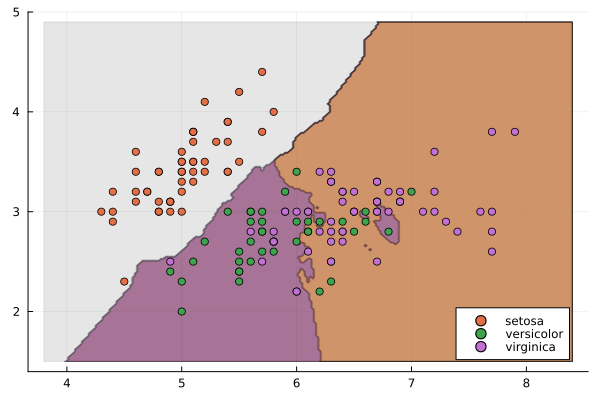

In [29]:
# code for Task 4: k=10
knnc = KNNClassifier(K=10)
knnc_ma = machine(knnc, X1, y)
MLJ.fit!(knnc_ma, rows=tr_inds)

dim1_min = minimum(X1[1])
dim1_max = maximum(X1[1])
xx = dim1_min-0.5:0.02:dim1_max+0.5
dim2_min = minimum(X1[2])
dim2_max = maximum(X1[2])
yy = dim2_min-0.5:0.02:dim2_max+0.5
z = []
for d1 in xx
    for d2 in yy
        push!(z, string(predict_mode(knnc_ma, [d1 d2])))
    end
end
zz = reshape(z, (length(yy), length(xx)))
        
zz = coerce(zz, OrderedFactor)
contourf(xx, yy, zz, bar=false, alpha=0.1, legend=false)
scatter!(X1[1], X1[2], group=y, legend=:bottomright)

[ Info: Training machine(KNNClassifier(K = 20, …), …).


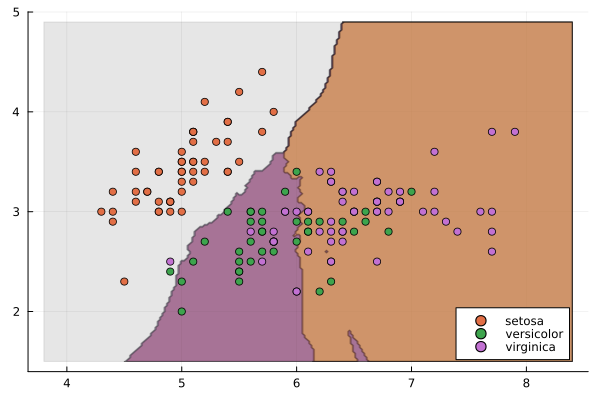

In [30]:
# code for Task 4: k=20
knnc = KNNClassifier(K=20)
knnc_ma = machine(knnc, X1, y)
MLJ.fit!(knnc_ma, rows=tr_inds)

dim1_min = minimum(X1[1])
dim1_max = maximum(X1[1])
xx = dim1_min-0.5:0.02:dim1_max+0.5
dim2_min = minimum(X1[2])
dim2_max = maximum(X1[2])
yy = dim2_min-0.5:0.02:dim2_max+0.5
z = []
for d1 in xx
    for d2 in yy
        push!(z, string(predict_mode(knnc_ma, [d1 d2])))
    end
end
zz = reshape(z, (length(yy), length(xx)))
        
zz = coerce(zz, OrderedFactor)
contourf(xx, yy, zz, bar=false, alpha=0.1, legend=false)
scatter!(X1[1], X1[2], group=y, legend=:bottomright)


Comments:

- The decision boundary becomes smoother when K increases
